In [10]:
import torch
from VSSParamsNNTorch import VSSParamNNTorch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from scipy.special import gamma

In [12]:
network = VSSParamNNTorch()
param_num = sum(p.numel() for p in network.parameters())
print(f"模型参数量：{param_num}")

for name, param in network.named_parameters():
    print(name)
    print(param.shape)

模型参数量：2345
B
torch.Size([])
K
torch.Size([])
alpha
torch.Size([])
kappa
torch.Size([])
_raw_rho
torch.Size([])
theta
torch.Size([])
X_0
torch.Size([])
q_fc1.weight
torch.Size([32, 2])
q_fc1.bias
torch.Size([32])
q_fc2.weight
torch.Size([32, 32])
q_fc2.bias
torch.Size([32])
q_fc3.weight
torch.Size([1, 32])
q_fc3.bias
torch.Size([1])
p_fc1.weight
torch.Size([32, 1])
p_fc1.bias
torch.Size([32])
p_fc2.weight
torch.Size([32, 32])
p_fc2.bias
torch.Size([32])
p_fc3.weight
torch.Size([1, 32])
p_fc3.bias
torch.Size([1])


In [5]:
def train(model, inputs, targets, epochs=500, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # 目标损失函数（可以根据需要更改）

    for epoch in range(epochs):
        model.train()
        
        optimizer.zero_grad()
        
        # 正常的前向传播
        outputs = model(inputs)
        
        # 计算标准的损失
        loss = criterion(outputs, targets)        
        
        # 总损失 = 传统损失
        total_loss = loss
        
        # 反向传播
        total_loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {total_loss.item()}')
            
    return model

In [6]:
def gen_pretrain_data(n=252, T=1):
    t = np.linspace(0, T, T*n+1)

    tj_1 = np.tile(t[:-1], T*n).reshape(T*n, T*n)  # Times tj excluding the final point
    ti_1 = tj_1.T  # Transpose to create a grid of ti values
    tj = np.tile(t[1:], T*n).reshape(T*n, T*n)  # Times tj excluding the initial point

    alpha = 0.279+0.5 ## H=0.279

    mask = tj <= ti_1
    KK = np.zeros((T*n,T*n))
    KK[mask] = (ti_1 ** alpha - (ti_1 - tj) ** alpha)[mask] / gamma(1 + alpha)

    t_train = ti_1[mask].reshape(-1,1)
    s_train = tj[mask].reshape(-1,1)

    inputs = np.concatenate([t_train, s_train], axis=1)
    inputs = torch.tensor(inputs, dtype=torch.float32)
    outputs = KK[mask].reshape(-1,1)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    return inputs, outputs

In [7]:
input_dim = 2  # 输入维度
hidden_dim = 32  # 隐藏层大小
output_dim = 1  # 输出维度

device = 'cuda'
# 创建模型
model = VSSParamNNTorch(input_size=input_dim, hidden_size=hidden_dim, output_size=output_dim, device=device)

inputs, targets = gen_pretrain_data(252, 6)
inputs = inputs.to(device)
targets = targets.to(device)
print(f"input shape: {inputs.shape}, target shape: {targets.shape}")

input shape: torch.Size([1142316, 2]), target shape: torch.Size([1142316, 1])


C:\Users\31251\AppData\Local\Temp\ipykernel_28016\515633575.py:12: RuntimeWarning: invalid value encountered in power
  KK[mask] = (ti_1 ** alpha - (ti_1 - tj) ** alpha)[mask] / gamma(1 + alpha)


In [6]:
trained_model = train(model, inputs, targets, epochs=500, lr=0.01)

Epoch 0/500, Loss: 0.01328287273645401
Epoch 10/500, Loss: 0.014031101018190384
Epoch 20/500, Loss: 0.010604183189570904
Epoch 30/500, Loss: 0.008038727566599846
Epoch 40/500, Loss: 0.006067128852009773
Epoch 50/500, Loss: 0.004874003119766712
Epoch 60/500, Loss: 0.0038774716667830944
Epoch 70/500, Loss: 0.00315473647788167
Epoch 80/500, Loss: 0.002598290564492345
Epoch 90/500, Loss: 0.0021653310395777225
Epoch 100/500, Loss: 0.001822504447773099
Epoch 110/500, Loss: 0.001550696324557066
Epoch 120/500, Loss: 0.0013318979181349277
Epoch 130/500, Loss: 0.0011540679261088371
Epoch 140/500, Loss: 0.0010079069761559367
Epoch 150/500, Loss: 0.0008865626878105104
Epoch 160/500, Loss: 0.0007848975947126746
Epoch 170/500, Loss: 0.0006990002584643662
Epoch 180/500, Loss: 0.0006258548819459975
Epoch 190/500, Loss: 0.0005631177918985486
Epoch 200/500, Loss: 0.0005089498590677977
Epoch 210/500, Loss: 0.0004618893435690552
Epoch 220/500, Loss: 0.00042076746467500925
Epoch 230/500, Loss: 0.0003846462

In [17]:
torch.save(trained_model.state_dict(), 'results/pretrain_network.pth')

In [8]:
trained_model = VSSParamNNTorch(input_size=input_dim, hidden_size=hidden_dim, output_size=output_dim, device=device)
trained_model.load_state_dict(torch.load('results/pretrain_network.pth', weights_only=False))
trained_model.eval()
print(trained_model.device)

cuda


In [16]:
print(type(trained_model))

trained_model = train(trained_model, inputs, targets, epochs=500, lr=0.01)

<class 'VSSParamsNNTorch.VSSParamNNTorch'>
Epoch 0/500, Loss: 8.130518835969269e-05
Epoch 10/500, Loss: 0.016151802614331245
Epoch 20/500, Loss: 0.0038396783638745546
Epoch 30/500, Loss: 0.000840983702801168
Epoch 40/500, Loss: 0.0004119843943044543
Epoch 50/500, Loss: 0.0004107389831915498
Epoch 60/500, Loss: 0.00035044204560108483
Epoch 70/500, Loss: 0.00029232390807010233
Epoch 80/500, Loss: 0.0002548696647863835
Epoch 90/500, Loss: 0.00021895102690905333
Epoch 100/500, Loss: 0.00016431942640338093
Epoch 110/500, Loss: 0.00011168025230290368
Epoch 120/500, Loss: 9.98611212708056e-05
Epoch 130/500, Loss: 8.996353426482528e-05
Epoch 140/500, Loss: 8.831390005070716e-05
Epoch 150/500, Loss: 8.638462895760313e-05
Epoch 160/500, Loss: 8.498575334670022e-05
Epoch 170/500, Loss: 8.349349081981927e-05
Epoch 180/500, Loss: 8.216131391236559e-05
Epoch 190/500, Loss: 8.08590411907062e-05
Epoch 200/500, Loss: 7.958055357448757e-05
Epoch 210/500, Loss: 7.831566472304985e-05
Epoch 220/500, Loss: 

0.4204436242580414
0.9949077367782593


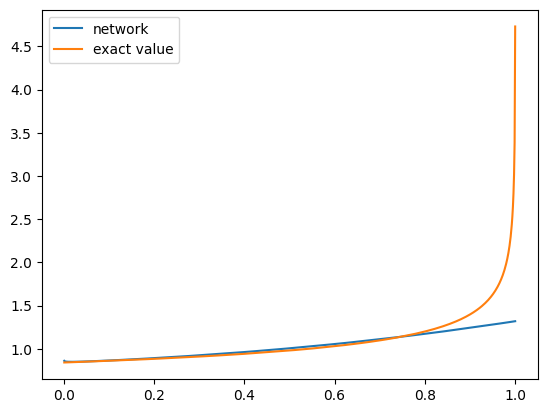

In [ ]:
# device = 'cuda'
device = 'cpu'

t_test = torch.ones(800,1, device=device)
s_test = torch.linspace(0, 1, 800, device=device).unsqueeze(1)

dt = s_test[1] - s_test[0]

trained_model = trained_model.to(device)

input_test= torch.cat([t_test, s_test], dim=1).float()
output_test = trained_model(input_test) 
alpha = torch.tensor(0.279+0.5, device=device)  ## H=0.279
gamma_value = gamma(1 + alpha.cpu().numpy())
gamma_value = torch.tensor(gamma_value, device=device)
target_test = (t_test ** alpha - (t_test - s_test) ** alpha) / gamma_value

output_kernal = (output_test[1:] - output_test[:-1]) / dt
target_kernal = (target_test[1:] - target_test[:-1]) / dt

print(trained_model.K.item())
print(trained_model.alpha.item())
plt.plot(s_test.detach().numpy(), output_test.detach().numpy(), label='network')
plt.plot(s_test.detach().numpy(), target_test.detach().numpy(), label='exact value')
# plt.plot(s_test[1:].cpu().detach().numpy(), output_kernal.cpu().detach().numpy(), label='network')
# plt.plot(s_test[1:].cpu().detach().numpy(), target_kernal.cpu().detach().numpy(), label='exact value')
plt.legend()
plt.show()